In [2]:
%pip install scikit-learn -q
%pip install pandas -q
%pip install numpy -q
%pip install matplotlib -q
%pip install seaborn -q
%pip install keras -q
%pip install os -q

%pip install cvxopt -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random
import seaborn as sns
import os
import cvxEDA

C:\Users\goert\AppData\Local\Temp\ipykernel_23392\2780907528.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:

MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/"

QUALITY_THRESHOLD = 128
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

In [5]:
dataset = pd.read_csv(DATA_PATH + "/merged_data.csv")

In [6]:
dataset.dtypes

w_eda                 float64
w_temp                float64
downsampled_labels    float64
ID                     object
Time                  float64
dtype: object

In [7]:
dataset

,w_eda,w_temp,downsampled_labels,ID,Time
0,1.138257,35.41,0.0,S2,0.00
1,1.125444,35.41,0.0,S2,0.25
2,1.011405,35.41,0.0,S2,0.50
3,1.033188,35.41,0.0,S2,0.75
4,0.935807,35.41,0.0,S2,1.00
...,...,...,...,...,...
347467,0.792287,31.81,0.0,S17,5918.75
347468,0.787170,31.81,0.0,S17,5919.00
347469,0.787170,31.81,0.0,S17,5919.25
347470,0.784611,31.81,0.0,S17,5919.50


In [35]:
import pandas as pd

# Function to create sequences DataFrame
def create_sequences_df(dataset, max_length=128):
    sequences = []
    temp_sequence = []
    eda_sequence = []
    label = None
    time_sequence = []
    current_id = None

    for index, row in dataset.iterrows():
        if current_id != row['ID']:
            # New ID encountered, append previous sequence to list
            if temp_sequence:
                sequences.append({
                    'ID': current_id,
                    'w_eda': eda_sequence,
                    'w_temp': temp_sequence,
                    'downsampled_label': label,
                    'Time': time_sequence
                })
            # Reset sequences for new ID
            temp_sequence = [row['w_temp']]
            eda_sequence = [row['w_eda']]
            label = row['downsampled_labels']
            time_sequence = [row['Time']]
            current_id = row['ID']
        else:
            # Append values to sequences
            temp_sequence.append(row['w_temp'])
            eda_sequence.append(row['w_eda'])
            time_sequence.append(row['Time'])

        # Check if sequence length exceeds max_length
        if len(temp_sequence) >= max_length:
            sequences.append({
                'ID': current_id,
                'w_eda': eda_sequence,
                'w_temp': temp_sequence,
                'downsampled_label': label,
                'Time': time_sequence
            })
            # Reset sequences for new ID
            temp_sequence = []
            eda_sequence = []
            label = None
            time_sequence = []
            current_id = None

    # Append last sequence if it's not empty
    if temp_sequence:
        sequences.append({
            'ID': current_id,
            'w_eda': eda_sequence,
            'w_temp': temp_sequence,
            'downsampled_label': label,
            'Time': time_sequence
        })

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    return sequences_df

# Create sequences DataFrame
sequences_df = create_sequences_df(dataset)

# Check the resulting DataFrame
sequences_df

,ID,w_eda,w_temp,downsampled_label,Time
0,S2,"[1.138257, 1.125444, 1.011405, 1.033188, 0.935...","[35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35....",transient,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2..."
1,S2,"[1.289355, 1.289355, 1.288074, 1.288074, 1.286...","[35.45, 35.45, 35.45, 35.45, 35.45, 35.45, 35....",transient,"[32.0, 32.25, 32.5, 32.75, 33.0, 33.25, 33.5, ..."
2,S2,"[0.962616, 0.958772, 0.94724, 0.943396, 0.9369...","[35.57, 35.57, 35.57, 35.57, 35.55, 35.55, 35....",transient,"[64.0, 64.25, 64.5, 64.75, 65.0, 65.25, 65.5, ..."
3,S2,"[1.135595, 1.131751, 1.131751, 1.129189, 1.126...","[35.49, 35.49, 35.49, 35.49, 35.49, 35.49, 35....",transient,"[96.0, 96.25, 96.5, 96.75, 97.0, 97.25, 97.5, ..."
4,S2,"[1.011306, 1.008744, 1.007462, 1.006181, 1.006...","[35.57, 35.57, 35.57, 35.57, 35.57, 35.57, 35....",transient,"[128.0, 128.25, 128.5, 128.75, 129.0, 129.25, ..."
...,...,...,...,...,...
2715,S17,"[1.012345, 1.005948, 1.004668, 1.00083, 0.9995...","[31.87, 31.87, 31.87, 31.87, 31.87, 31.87, 31....",transient,"[5760.0, 5760.25, 5760.5, 5760.75, 5761.0, 576..."
2716,S17,"[1.003389, 0.995713, 0.996992, 0.993154, 0.995...","[31.91, 31.91, 31.91, 31.91, 31.91, 31.91, 31....",transient,"[5792.0, 5792.25, 5792.5, 5792.75, 5793.0, 579..."
2717,S17,"[0.981639, 0.976522, 0.97908, 0.97908, 0.98036...","[31.97, 31.93, 31.93, 31.93, 31.93, 31.93, 31....",transient,"[5824.0, 5824.25, 5824.5, 5824.75, 5825.0, 582..."
2718,S17,"[0.963728, 0.95861, 0.965007, 0.976522, 0.9765...","[31.93, 31.95, 31.95, 31.95, 31.95, 31.93, 31....",transient,"[5856.0, 5856.25, 5856.5, 5856.75, 5857.0, 585..."


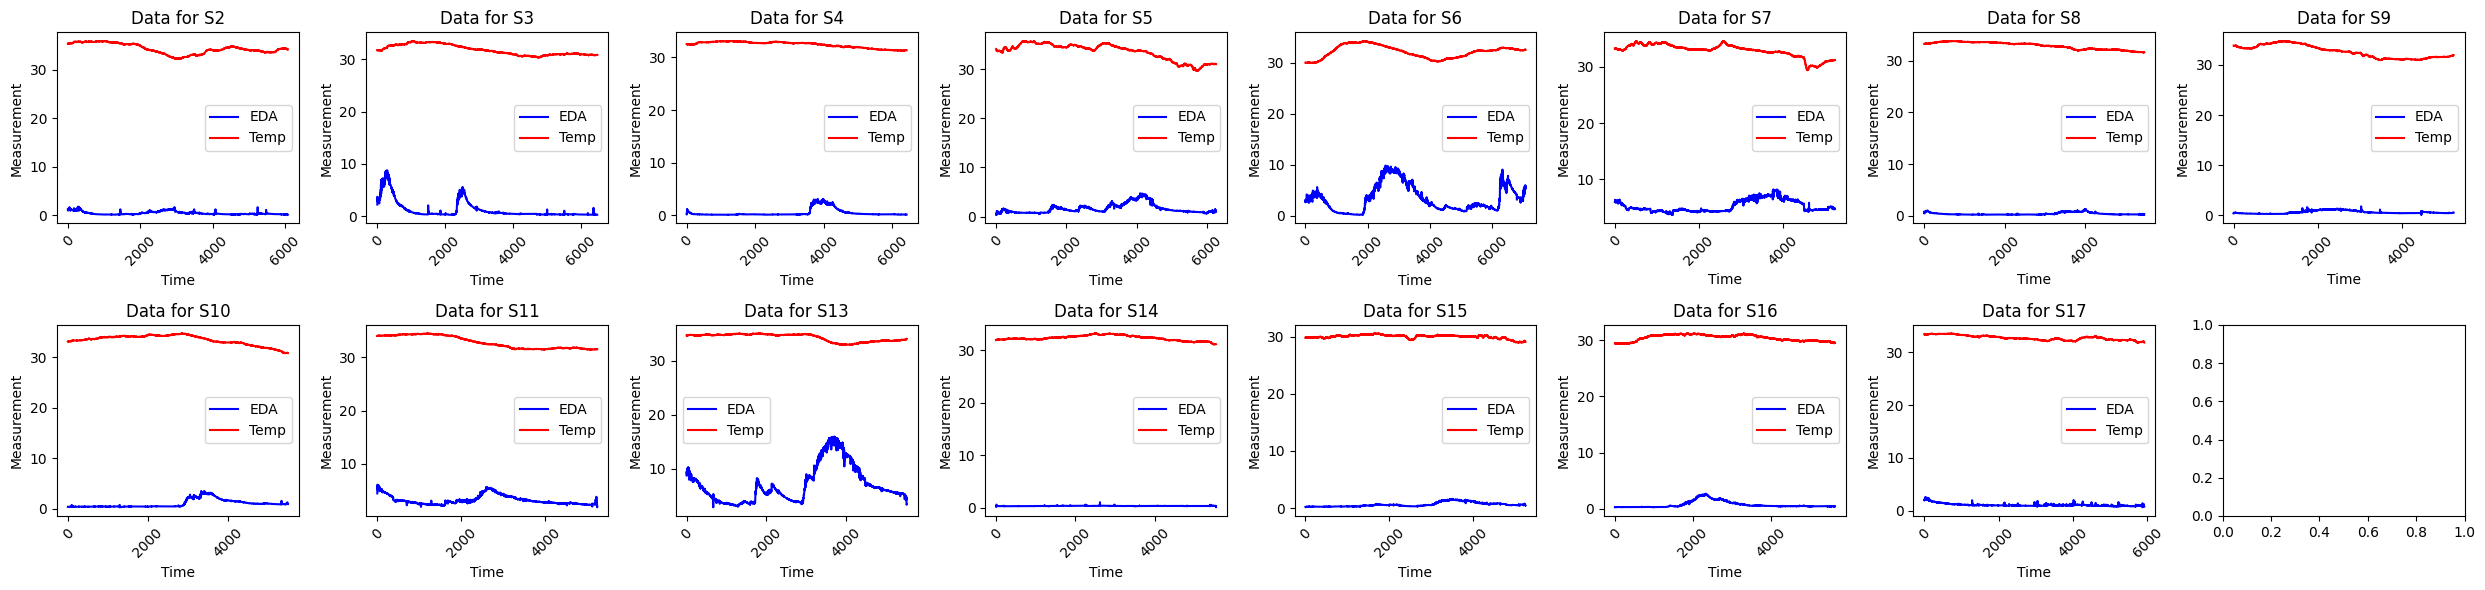

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 8, figsize=(25, 6))  # Increased figure size
axes = axes.flatten()

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Iterate through each unique id
for i, unique_id in enumerate(unique_ids):
    if i < len(unique_ids):
        # Filter data for each id
        subset_data = dataset[dataset['ID'] == unique_id]
        
        # Plotting
        sns.lineplot(x='Time', y='w_eda', data=subset_data, ax=axes[i], color='blue', label='EDA')
        sns.lineplot(x='Time', y='w_temp', data=subset_data, ax=axes[i], color='red', label='Temp')

        axes[i].set_title(f"Data for {unique_id}")
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Measurement')
        axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [8]:
# import matplotlib.pyplot as plt

# # Create subplots
# fig, axes = plt.subplots(16, 3, figsize=(60, 40))  # Increased figure size

# # Define colors for each acceleration component
# colors = ['red', 'green', 'blue']

# # Iterate through each unique id
# for i, unique_id in enumerate(unique_ids):
#     # Filter data for each id
#     subset_data = dataset[dataset['ID'] == unique_id]
    
#     # Iterate through X, Y, and Z accelerations
#     for j, accel_component in enumerate(['X', 'Y', 'Z']):
#         ax = axes[i, j]  # Select the appropriate subplot
        
#         # Plot acceleration component with different color
#         ax.plot(subset_data['Time'], subset_data[accel_component], label=f'{accel_component} Acceleration', color=colors[j])
#         ax.set_title(f"Data for {unique_id} - {accel_component} Acceleration")
#         ax.set_xlabel('Time')
#         ax.set_ylabel('Acceleration')
#         ax.legend()
#         ax.tick_params(axis='x', rotation=45)

# # Adjust layout
# plt.tight_layout()
# plt.show()


In [121]:
import cvxEDA.src.cvxEDA

def calculate_eda_levels(y):
    fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700}
    Fs = fs_dict['EDA']
    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA.src.cvxEDA.cvxEDA(yn, 1. / Fs)
    return [p, t]


In [36]:
import matplotlib.pyplot as plt

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Iterate through each unique id
for unique_id in unique_ids:
    # Filter data for each id
    subset_data = dataset[dataset['ID'] == unique_id]
    
    # Calculate EDA levels
    tonic, phasic = calculate_eda_levels(subset_data['w_eda'].values)
    
    # Plotting
    plt.plot(tonic, label='Tonic')
    plt.plot(phasic, label='Phasic')
    plt.plot(subset_data['w_eda'].values, label='EDA')
    
    plt.xlabel('Time')
    plt.ylabel('EDA Levels')
    plt.title(f'Phasic and Tonic EDA for ID: {unique_id}')
    plt.legend()
    plt.show()


NameError: name 'calculate_eda_levels' is not defined

In [39]:
print("Before replacing labels")
unique_labels_before = sequences_df['downsampled_label'].unique()
print(unique_labels_before, "\n")
print("Number of unique labels before replacement:", len(unique_labels_before), "\n")


Before replacing labels
['transient' 'baseline' 'stress' 'meditation' 'amusement'] 

Number of unique labels before replacement: 5 



In [40]:

dataset.replace(
    {
        "downsampled_labels": {
            0: "transient",
            1: "baseline",
            2: "stress",
            3: "amusement",
            4: "meditation",
            5: "ignored",
            6: "ignored",
            7: "ignored",
        }
    },
    inplace=True,
)


In [41]:
from sklearn import preprocessing

print("After replacing labels")
unique_labels_after = sequences_df['downsampled_label'].unique()
print(unique_labels_after)
print("Number of unique labels after replacement:", len(unique_labels_after))

le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(sequences_df['downsampled_label'])
sequences_df['downsampled_label'] = le.transform(sequences_df['downsampled_label'])


After replacing labels
['transient' 'baseline' 'stress' 'meditation' 'amusement']
Number of unique labels after replacement: 5


In [42]:
num_classes = len(sequences_df['downsampled_label'].unique())
print(num_classes)


5


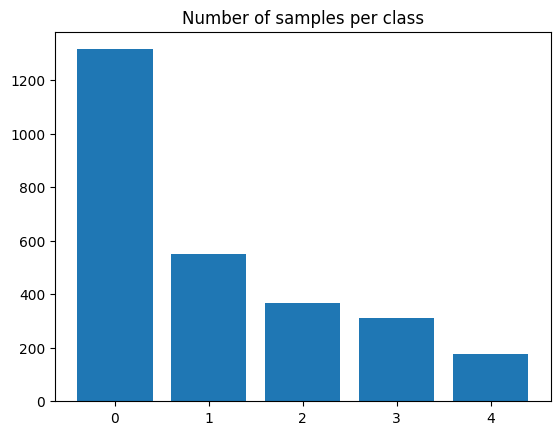

In [43]:
plt.bar(range(num_classes), sequences_df['downsampled_label'].value_counts())
plt.title("Number of samples per class")
plt.show()


****Scale and split data****

We perform a simple Min-Max scaling to bring the value-range between 0 and 1. We do not use Standard Scaling as the data does not follow a Gaussian distribution.

In [44]:
# Scale the 'w_eda' feature
scaler = preprocessing.MinMaxScaler()
series_list = [
    scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in sequences_df["w_eda"]
]

# Separate the labels
labels_list = [i for i in sequences_df['downsampled_label']]

print(len(series_list))
print(len(labels_list))


2720
2720


In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding sequences to ensure uniform length
max_sequence_length = 128  # Choose the desired maximum sequence length
padded_series_list = pad_sequences(series_list, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Splitting data into training and testing sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    padded_series_list, labels_list, test_size=0.15, random_state=42, shuffle=True
)

# Convert to numpy arrays and reshape for compatibility with Keras
x_train = np.asarray(x_train).astype(np.float32).reshape(-1, max_sequence_length, 1)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, max_sequence_length, 1)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

# Check lengths of train and test sets
print(
    f"Length of x_train : {len(x_train)}\nLength of x_test : {len(x_test)}\nLength of y_train : {len(y_train)}\nLength of y_test : {len(y_test)}"
)


Length of x_train : 2312
Length of x_test : 408
Length of y_train : 2312
Length of y_test : 408


In [47]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [48]:
vals_dict = {}
for i in sequences_df['downsampled_label']:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)



{4: 0.5161764705882352, 1: 0.7974264705882352, 3: 0.8852941176470588, 2: 0.8654411764705883, 0: 0.9356617647058824}


In [49]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [54]:
def create_model():
    input_layer = keras.Input(shape=(128, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024,
        kernel_size=7,
        strides=2,
        activation="relu",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    # Add Flatten layer after the last convolutional layer
    x = layers.Flatten()(x)
    print("Shape after Flatten:", x.shape)
    
    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        2048, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        1024, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)


In [55]:
conv_model = create_model()
conv_model.summary()


Shape after Flatten: (None, 2048)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 64, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 32, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 8, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 4, 512)         │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 4, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 2, 1024)        │     3,671,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 2, 1024)        │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │       131,20

 Total params: 23,822,021 (90.87 MB)

 Trainable params: 23,817,989 (90.86 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [56]:
epochs = 60

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_top_k_categorical_accuracy",
        factor=0.2,
        patience=2,
        min_lr=0.000001,
    ),
]

optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()


In [57]:

conv_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        keras.metrics.TopKCategoricalAccuracy(k=3),
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

conv_model_history = conv_model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_dataset,
    class_weight=weight_dict,
)


Epoch 1/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - auc_2: 0.6755 - loss: 33.6689 - precision_2: 0.4694 - recall_2: 0.1596 - top_k_categorical_accuracy: 0.7884 - val_auc_2: 0.7286 - val_loss: 9.3512 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_top_k_categorical_accuracy: 0.7868 - learning_rate: 0.0010
Epoch 2/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 381ms/step - auc_2: 0.7805 - loss: 6.5228 - precision_2: 0.5403 - recall_2: 0.1126 - top_k_categorical_accuracy: 0.8882 - val_auc_2: 0.7071 - val_loss: 3.4513 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_top_k_categorical_accuracy: 0.7868 - learning_rate: 0.0010
Epoch 3/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 383ms/step - auc_2: 0.8018 - loss: 2.6004 - precision_2: 0.5932 - recall_2: 0.2232 - top_k_categorical_accuracy: 0.8896 - val_auc_2: 0.7378 - val_loss: 2.3850 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_top_k_categorical_accuracy: 0.7672 - learning_rate: 0.0010
Epoch 4/60
37/37 ━━━━━━━━━━━━━

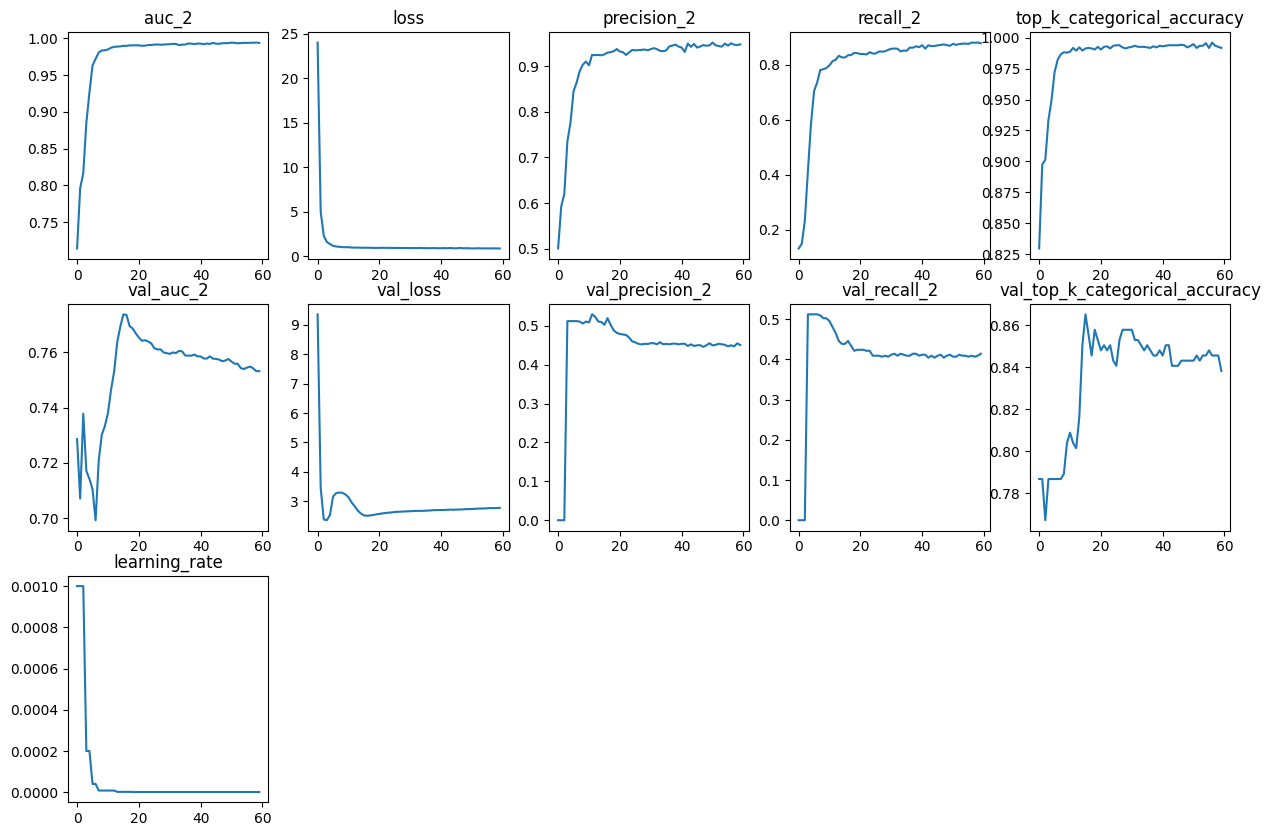

In [58]:
plot_history_metrics(conv_model_history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc_2: 0.7449 - loss: 2.9005 - precision_2: 0.4377 - recall_2: 0.4017 - top_k_categorical_accuracy: 0.8345
Loss : 2.7820894718170166
Top 3 Categorical Accuracy : 0.753183901309967
Area under the Curve (ROC) : 0.4506666660308838
Precision : 0.41421568393707275
Recall : 0.8382353186607361


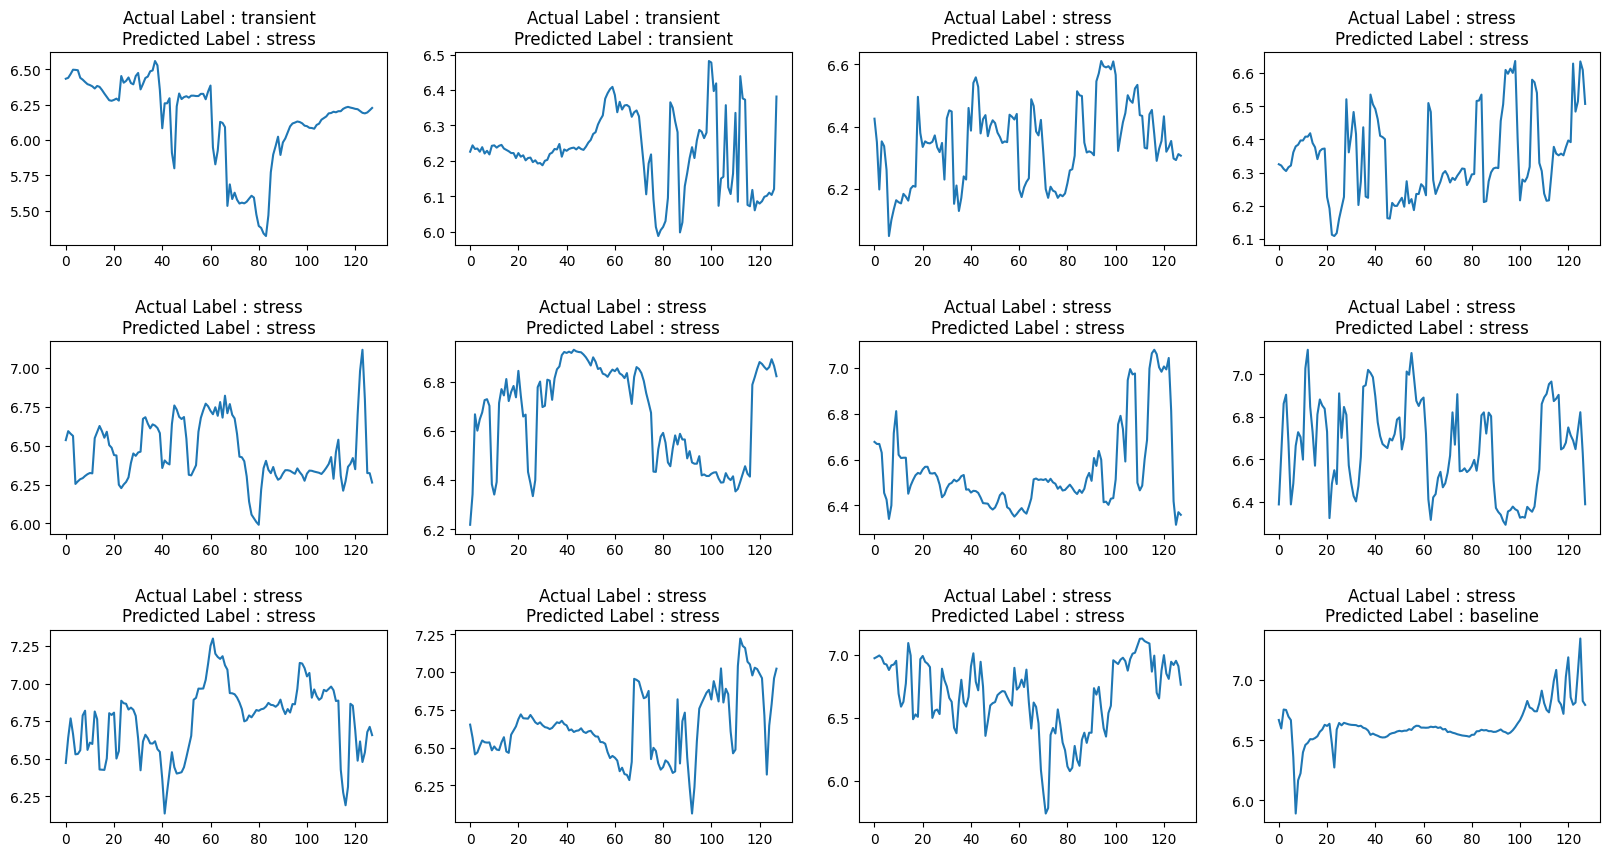

In [61]:
loss, accuracy, auc, precision, recall = conv_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")


def view_evaluated_eeg_plots(model):
    start_index = random.randint(10, len(sequences_df))
    end_index = start_index + 11
    data = sequences_df.loc[start_index:end_index, 'w_eda']
    data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
    data_array = [np.asarray(data_array).astype(np.float32).reshape(-1, 128, 1)]
    original_labels = sequences_df.loc[start_index:end_index, 'downsampled_label']
    predicted_labels = np.argmax(model.predict(data_array, verbose=0), axis=1)
    original_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in original_labels
    ]
    predicted_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in predicted_labels
    ]
    total_plots = 12
    cols = total_plots // 3
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1
    pos = range(1, total_plots + 1)
    fig = plt.figure(figsize=(20, 10))
    for i, (plot_data, og_label, pred_label) in enumerate(
        zip(data, original_labels, predicted_labels)
    ):
        plt.subplot(rows, cols, pos[i])
        plt.plot(plot_data)
        plt.title(f"Actual Label : {og_label}\nPredicted Label : {pred_label}")
        fig.subplots_adjust(hspace=0.5)
    plt.show()


view_evaluated_eeg_plots(conv_model)
